In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import keras
from keras import Model
from keras.layers import Embedding, Input, Flatten, Dot, Add
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [4]:
import mlflow

# Set MLFlow Experiment
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment(experiment_name="recommendation_system")

<Experiment: artifact_location='mlflow-artifacts:/753183866456602941', creation_time=1721774674814, experiment_id='753183866456602941', last_update_time=1721774674814, lifecycle_stage='active', name='recommendation_system', tags={}>

In [31]:
keras.config.enable_unsafe_deserialization()

# Load Data

In [5]:
ratings = pd.read_csv("data/scores.csv", index_col=0)

# Create a dictionary of indexes for the users and movies maping every ID to a given index.
u_unique = ratings.user_id.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movie_id.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

# Replace the users and movies ids with the new index value.
ratings.user_id = ratings.user_id.apply(lambda x: user2Idx[x])
ratings.movie_id = ratings.movie_id.apply(lambda x: movie2Idx[x])

n_users = int(ratings.user_id.nunique())
n_movies = int(ratings.movie_id.nunique())

## Load Model

In [6]:
keras_model = "runs:/7cebf8018fba4b4cb6640762b2da5c2e/keras_model"
keras_baseline_model = "runs:/e6ce9f86e3504e2c816b4d80a5c4d387/keras_model"
keras_gender_model = "runs:/5b9c6aed94114978a8412f69549ea353/keras_model"

In [7]:
model = mlflow.keras.load_model(model_uri=keras_baseline_model)

C:\Users\leona\anaconda3\envs\deeplearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
layers = {layer.name: layer for layer in model.layers}
layers

{'Item': <InputLayer name=Item, built=True>,
 'User': <InputLayer name=User, built=True>,
 'Movie-Embedding': <Embedding name=Movie-Embedding, built=True>,
 'User-Embedding': <Embedding name=User-Embedding, built=True>,
 'FlattenMovies': <Flatten name=FlattenMovies, built=True>,
 'FlattenUsers': <Flatten name=FlattenUsers, built=True>,
 'User-Bias-Embedding': <Embedding name=User-Bias-Embedding, built=True>,
 'Movie-Bias-Embedding': <Embedding name=Movie-Bias-Embedding, built=True>,
 'DotProduct': <Dot name=DotProduct, built=True>,
 'FlattenUserBias': <Flatten name=FlattenUserBias, built=True>,
 'FlattenMoviesBias': <Flatten name=FlattenMoviesBias, built=True>,
 'add_4': <Add name=add_4, built=True>}

## K-Means

In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [11]:
movies = pd.read_csv("data/peliculas.csv")
users = pd.read_csv("data/usuarios.csv")
movies["Release Date"] = pd.to_datetime(movies["Release Date"])

In [12]:
users['userIdx'] = users['id'].apply(lambda x: user2Idx[x])
movies['movieIdx'] = movies['id'].apply(lambda x: movie2Idx[x])

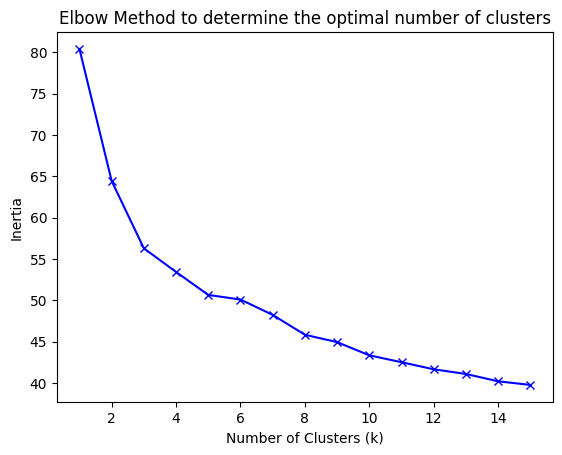

In [13]:
inertias = []
movie_embeddings = layers["Movie-Embedding"].get_weights()[0] # Substitua pelos seus embeddings
k_values = range(1, 16)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(movie_embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to determine the optimal number of clusters')
plt.show()

In [14]:
from sklearn.manifold import TSNE

In [15]:
action_vector = [0] + movies.sort_values(by="movieIdx")["Action"].to_list()

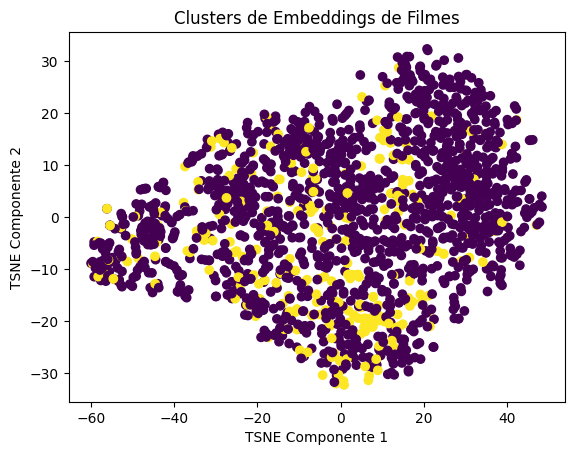

In [17]:
# Predicting clusters
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(movie_embeddings)

# Dimensionality reduction using TSNE
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(movie_embeddings)

# Plot clusters
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=action_vector)
plt.title('Clusters de Embeddings de Filmes')
plt.xlabel('TSNE Componente 1')
plt.ylabel('TSNE Componente 2')
plt.show()

In [18]:
movies["cluster"] = clusters[movies.movieIdx]

In [19]:
def plot_stats(df: pd.DataFrame, gender: list = None) -> None:
    """Helper method to plot movies dataframe stats

    Parameters
    ----------
    df : pd.DataFrame
        Pandas dataframe with the movies information to be plotted.
    gender : list, default None
        List of genders to filter the Gender bar plot.
    """
    sns.set_style("ticks")
    fig, axes = plt.subplot_mosaic(
        [["Gender", "Gender"]], figsize=(12, 8)
    )
    if not gender:
        int_cols = df.select_dtypes(include=["int64"]).columns.to_list()
        int_cols.remove("id")
    else:
        int_cols = gender
    gender_df = pd.DataFrame(
        df[int_cols]
        .melt()
        .groupby("variable")
        .value.sum()
        .sort_values(ascending=False)
    ).reset_index()
    gender_labels = gender_df["variable"].to_list()
    sns.barplot(
        data=gender_df,
        x="variable",
        y="value",
        hue="value",
        palette="Greens_d",
        legend=False,
    )
    axes["Gender"].set_ylabel("Frequency")
    axes["Gender"].set_xlabel("Gender")
    axes["Gender"].set_xticks(range(len(gender_labels)))  # Set the ticks
    axes["Gender"].set_xticklabels(gender_labels, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

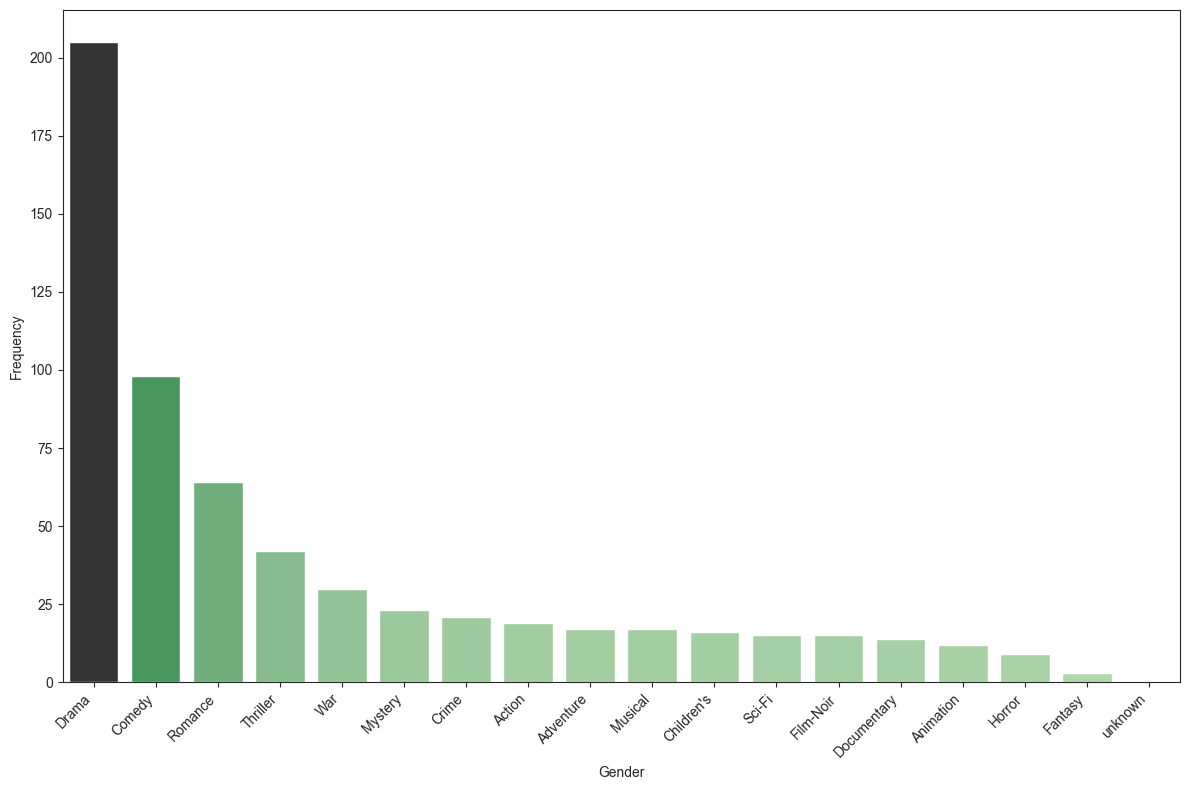

In [20]:
gender_melt = plot_stats(movies[movies.cluster == 0].iloc[:, :-3])

In [21]:
movies[movies.cluster == 0]

,id,Name,Release Date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieIdx,cluster
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995-01-01,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1060,0
6,7,Twelve Monkeys (1995),1995-01-01,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,210,0
7,8,Babe (1995),1995-01-01,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,390,0
8,9,Dead Man Walking (1995),1995-01-01,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,503,0
9,10,Richard III (1995),1996-01-22,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,189,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,1467,"Saint of Fort Washington, The (1993)",1993-01-01,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1620,0
1511,1512,"World of Apu, The (Apur Sansar) (1959)",1996-04-05,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1429,0
1523,1524,Kaspar Hauser (1993),1996-06-07,http://us.imdb.com/Title?Kaspar+Hauser+(1993),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1272,0
1536,1537,Cosi (1996),1997-04-11,http://us.imdb.com/M/title-exact?Cosi%20(1996),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1415,0
